In [15]:
# --- Setup AOI and output folders ---
from shapely.geometry import box, mapping
from pathlib import Path
from pystac_client import Client
import planetary_computer as pc
import rasterio
import rasterio.mask
from shapely.geometry import box
from shapely.ops import transform
from pyproj import Transformer
import numpy as np
import matplotlib.pyplot as plt
import requests
import geopandas as gpd
from shapely.geometry import LineString
import folium, os

# (lon/lat, EPSG:4326)

minx, miny, maxx, maxy = -122.232, 47.696, -122.202, 47.716
AOI = box(minx, miny, maxx, maxy)

OUT = Path("outputs"); OUT.mkdir(exist_ok=True, parents=True)
print("AOI bbox:", minx, miny, maxx, maxy)
print("Outputs →", OUT.resolve())

AOI bbox: -122.232 47.696 -122.202 47.716
Outputs → /Users/anapaola/Documents/Repos/wildfire_powerlines/notebooks/outputs


In [16]:
# --- Fetch NAIP (COG) and clip to AOI ---

stac = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

search = stac.search(
    collections=["naip"],
    intersects=mapping(AOI),
    sortby=[{"field": "datetime", "direction": "desc"}],  # latest first
    limit=1,
)

item = next(search.get_items())
signed = pc.sign(item)
cog_href = signed.assets["image"].href

print("STAC item:", item.id)
print("COG:", cog_href)

with rasterio.open(cog_href) as src:
    print("Raster CRS:", src.crs)
    print("Raster bounds:", src.bounds)

    # AOI is in EPSG:4326; reproject it to the raster's CRS
    to_raster = Transformer.from_crs("EPSG:4326", src.crs, always_xy=True).transform
    AOI_in_raster = transform(to_raster, AOI)

    # quick sanity: do they overlap?
    if not AOI_in_raster.intersects(box(*src.bounds)):
        raise ValueError("AOI does not intersect this NAIP tile after reprojection. "
                         "Try adjusting the AOI or fetching a different item.")

    img, transform_aff = rasterio.mask.mask(
        src, [AOI_in_raster.__geo_interface__], crop=True
    )
    meta = src.meta.copy()
    meta.update(height=img.shape[1], width=img.shape[2], transform=transform_aff)

out_tif = OUT / "naip_aoi.tif"
with rasterio.open(out_tif, "w", **meta) as dst:
    dst.write(img)

print("Saved:", out_tif, "| shape:", img.shape)


/Users/anapaola/Documents/Repos/wildfire_powerlines/.venv/lib/python3.12/site-packages/pystac_client/item_search.py:925: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


STAC item: wa_m_4712223_nw_10_060_20231007_20240209
COG: https://naipeuwest.blob.core.windows.net/naip/v002/wa/2023/wa_060cm_2023/47122/m_4712223_nw_10_060_20231007_20240209.tif?st=2025-09-06T15%3A15%3A09Z&se=2025-09-07T16%3A00%3A09Z&sp=rl&sv=2025-07-05&sr=c&skoid=9c8ff44a-6a2c-4dfb-b298-1c9212f64d9a&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2025-09-06T14%3A48%3A40Z&ske=2025-09-13T14%3A48%3A40Z&sks=b&skv=2025-07-05&sig=Xj5YV/lR5joJg3oseavKCINJnJwb1rEL8CchATtPObg%3D
Raster CRS: EPSG:26910
Raster bounds: BoundingBox(left=556014.0, bottom=5281638.0, right=561174.0, top=5289036.0)
Saved: outputs/naip_aoi.tif | shape: (4, 3743, 3789)


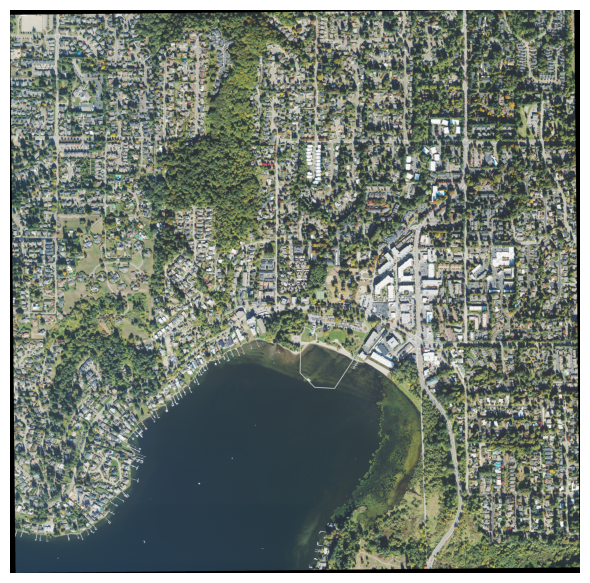

Saved preview: outputs/naip_aoi_thumb.png


In [17]:
# --- Tiny PNG preview of the clipped NAIP ---

thumb_png = OUT / "naip_aoi_thumb.png"
with rasterio.open(out_tif) as src:
    arr = src.read()  # shape: (bands, H, W)
    # pick RGB if present; NAIP is typically 4-band (RGBN)
    if arr.shape[0] >= 3:
        rgb = np.clip(np.moveaxis(arr[:3], 0, -1), 0, 255).astype(np.uint8)
    else:
        rgb = np.repeat(arr[0][..., None], 3, axis=2).astype(np.uint8)

plt.figure(figsize=(6, 6))
plt.imshow(rgb)
plt.axis("off")
plt.tight_layout()
plt.savefig(thumb_png, dpi=150)
plt.show()

print("Saved preview:", thumb_png)


In [18]:
# --- Overpass query for highways (major road classes) ---


HIGHWAY_CLASSES = [
    "motorway","trunk","primary","secondary","tertiary",
    "motorway_link","trunk_link","primary_link","secondary_link","tertiary_link"
]
regex = "^(" + "|".join(HIGHWAY_CLASSES) + ")$"

south, west, north, east = miny, minx, maxy, maxx  # Overpass bbox order
overpass_url = "https://overpass-api.de/api/interpreter"

#  request geometry directly
q = f"""
[out:json][timeout:60];
(
  way["highway"~"{regex}"]({south},{west},{north},{east});
);
out geom;
"""
resp = requests.post(overpass_url, data={"data": q})
resp.raise_for_status()
data = resp.json()

# Build LineStrings from returned geometry
features = []
for el in data.get("elements", []):
    if el.get("type") == "way" and "geometry" in el:
        coords = [(pt["lon"], pt["lat"]) for pt in el["geometry"]]
        if len(coords) >= 2:
            props = el.get("tags", {})
            props["osm_id"] = el.get("id")
            features.append({
                "type": "Feature",
                "geometry": {"type": "LineString", "coordinates": coords},
                "properties": props
            })

roads_wgs84 = gpd.GeoDataFrame.from_features(features, crs="EPSG:4326")
print(f"Fetched {len(roads_wgs84)} highway features")

# Reproject to raster CRS and buffer (e.g., 30 m)
with rasterio.open(out_tif) as src:
    raster_crs = src.crs

roads_proj = roads_wgs84.to_crs(raster_crs)
buf_m = 30
roads_buf = roads_proj.copy()
roads_buf["geometry"] = roads_proj.geometry.buffer(buf_m)

GPKG_HIGHWAYS = OUT / "highways_aoi.gpkg"
roads_proj.to_file(GPKG_HIGHWAYS, layer="lines", driver="GPKG")
roads_buf.to_file(GPKG_HIGHWAYS, layer="lines_buffer", driver="GPKG")
print("Saved:", GPKG_HIGHWAYS)


Fetched 59 highway features
Saved: outputs/highways_aoi.gpkg


In [19]:
# --- Folium map (AOI + roads) ---


# ensure output dir exists
OUT.mkdir(parents=True, exist_ok=True)

# center map on AOI center (WGS84 coords)
center_lat = (miny + maxy) / 2
center_lon = (minx + maxx) / 2
m = folium.Map(location=[center_lat, center_lon], zoom_start=14, control_scale=True)

# AOI rectangle (WGS84)
folium.Rectangle(bounds=[(miny, minx), (maxy, maxx)],
                 color="blue", weight=2, fill=False).add_to(m)


roads_wgs84 = roads_proj.to_crs(4326)

# easiest: add as GeoJSON in one shot
folium.GeoJson(
    data=roads_wgs84.__geo_interface__,
    name="Highways",
    style_function=lambda feat: {"color": "red", "weight": 2, "opacity": 0.8},
).add_to(m)
folium.LayerControl().add_to(m)

html_map = OUT / "map_aoi_roads.html"
m.save(str(html_map))
print("Saved:", html_map, "size:", os.path.getsize(html_map), "bytes")

# (optional) show a clickable link in notebooks
try:
    from IPython.display import display
    display(html_map)
except Exception:
    pass


Saved: outputs/map_aoi_roads.html size: 78584 bytes


PosixPath('outputs/map_aoi_roads.html')